In [1]:
import matplotlib.pyplot as plt
if __name__ == '__main__':
    %matplotlib inline
    !jupyter nbconvert --to script PV_forecast_function_notebook.ipynb
    !jupyter nbconvert --to script Forecast_functions_V2.ipynb

[NbConvertApp] Converting notebook PV_forecast_function_notebook.ipynb to script
[NbConvertApp] Writing 117729 bytes to PV_forecast_function_notebook.py
[NbConvertApp] Converting notebook Forecast_functions_V2.ipynb to script
[NbConvertApp] Writing 27160 bytes to Forecast_functions_V2.py


# Testing

In [2]:
if __name__ == '__main__':
    #from MPCforecasting_V2 import example_inputs1, Forecasting, standard_plot1
    from Forecast_functions_V2 import example_inputs1, Forecasting, standard_plot1

C:\Users\Christoph\Documents\PrivateRepos\ESTCP-Controller\controller\forecaster\old_cyder\Forecast_functions_V2.py:211: Warning: Forecast model "NN" not loaded properly. Setting loaded = False.
Exception:
name 'joblib' is not defined
Traceback:
Traceback (most recent call last):
  File "C:\Users\Christoph\Documents\PrivateRepos\ESTCP-Controller\controller\forecaster\old_cyder\Forecast_functions_V2.py", line 207, in load_models
    self.models['nn']['model'] = joblib.load(self.models['nn']['path'])
NameError: name 'joblib' is not defined


  warnings.warn('Forecast model "NN" not loaded properly. Setting loaded = False.\nException:\n'+                               str(e)+'\nTraceback:\n'+str(traceback.format_exc())+'\n', Warning)


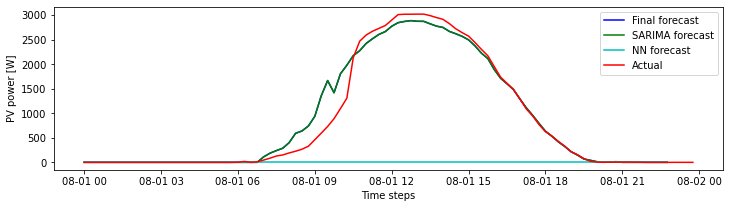

In [3]:
if __name__ == '__main__':
    obsDf, wfDf, PVactual, models, config = example_inputs1()
    test_forecasting = Forecasting(models=models, config=config)
    pv_fc = test_forecasting.do_forecast(obsDf, wfDf)
    standard_plot1(test_forecasting, PVactual)

# Development

In [ ]:
#!/usr/bin/env python
'''
    INTERNAL USE ONLY
    Forecaster for Smart Inverter Project
    cgehbauer@lbl.gov
    
    Version V1.0:
    -) Added wrapper function.
    -) Example inputs 1 for 8/1/2018.
    -) Added standard plot 1.
    -) Automated download from NOAA.
    -) Added clearsky calculation.
    Version V2:
    -) Modified default values for forecast.
    -) Added loaded=False when error loading model.
'''

import time
from datetime import datetime, timedelta
import os
import pandas as pd
import numpy as np
#from sklearn.externals import joblib
import json
import matplotlib.pyplot as plt
from requests import get
from xml.dom import minidom
import urllib3
urllib3.disable_warnings()
from pvlib.location import Location
from pvlib import irradiance
import traceback
import warnings

#import nbimporter
from PV_forecast_function_notebook import getPVforecast_v4

def get_forecast_noaa(now, config, timeout=5, wf_prev=pd.DataFrame()):
    dt_fmt = '%Y-%m-%d %H:%M:%S'
    try:
        response = get('http://forecast.weather.gov/MapClick.php?lat='+ \
                       str(config['location_latitude'])+'&lon='+ \
                       str(config['location_longitude'])+'&FcstType=digitalDWML', \
                       verify=False, timeout=timeout).text.encode('ascii','ignore')
        xmldoc = minidom.parseString(response)
        itemlist = xmldoc.getElementsByTagName('start-valid-time')
        forecast = [['date_time', xmldoc.getElementsByTagName('temperature')[2].attributes['type'].value, 'cloud_cover']]
        tz = int(str(xmldoc.getElementsByTagName('start-valid-time')[0].firstChild.nodeValue)[19:22])
        for i in range(len(xmldoc.getElementsByTagName('start-valid-time'))):
            temp = []
            temp.append(datetime.strptime(str(xmldoc.getElementsByTagName('start-valid-time')[i].firstChild.nodeValue)[0:19], '%Y-%m-%dT%H:%M:%S').strftime(dt_fmt))
            temp.append(round((float(xmldoc.getElementsByTagName('temperature')[2].getElementsByTagName('value')[i].firstChild.nodeValue)-32)*(5/9.), 1))
            temp.append(float(xmldoc.getElementsByTagName('cloud-amount')[0].getElementsByTagName('value')[i].firstChild.nodeValue))
            forecast.append(temp)
        wf = pd.DataFrame(forecast[1::], columns=forecast[0])
        wf.index = pd.to_datetime(wf['date_time']) # Local time (from NOAA)
        wf = wf.tz_localize('Etc/GMT'+'{:+d}'.format(-1*tz)).tz_convert('Etc/GMT'+'{:+d}'.format(-1*config['tz_st'])) # Convert to standard time 
        now_hourly = datetime(year=now.year,month=now.month,day=now.day,hour=now.hour,minute=now.minute) # now must be in standard time!
        now_hourly = now.replace(second=0) #+ timedelta(hours=1)
        wf = wf.resample('1T').interpolate().resample('60T',base=now.minute).asfreq() # Interpolate
        wf = wf.loc[now_hourly:now_hourly+timedelta(days=1,hours=-2)]
        wf = calculate_clearsky(wf, config)
        wf = wf[['hourly','cloud_cover','poa_global']]
        wf = wf.rename(columns={'hourly':'Tamb_forecast','cloud_cover':'cloud_cover_forecast','poa_global':'clear_sky_forecast'})
        wf.index = wf.index.tz_localize(None)
        wf = pd.Series(wf.to_dict(orient='list'))
        wf['timeIndex'] = now.strftime(dt_fmt)
        wf['valid'] = True
        return wf, ''
    except Exception as e:
        #print wf_prev
        #print len(wf_prev)
        if len(wf_prev) == 5:
            status = 'Using previous forecast instead.'
            wf = wf_prev
            wf['valid'] = True
        else:
            status = 'Using [0]*23 array instead.'
            wfDf = {"Tamb_forecast":[22.0]*23,"clear_sky_forecast":[0.0]*23,"cloud_cover_forecast":[100.0]*23,"timeIndex":now.strftime(dt_fmt)}
            wf = pd.Series(wfDf)
            wf['valid'] = False
        warnings.warn('Problem when generated NOAA forecast. '+status+'\nException:\n'+ \
            str(e)+'\nTraceback:\n'+str(traceback.format_exc())+'\n', Warning)
        return wf, 'Error-NOAA forecast\n'
    
def calculate_clearsky(wf, config):
    loc = Location(config['location_latitude'], config['location_longitude'], config['tz_st'], 276, 'Location')
    wf = wf.join(loc.get_clearsky(wf.index))
    wf = wf.join(loc.get_solarposition(wf.index))
    wf = wf.join(irradiance.get_total_irradiance(0, 180, wf['apparent_zenith'], wf['azimuth'], \
                                        wf['dni'],wf['ghi'],wf['dhi']))
    wf = wf.round(1)
    return wf

class Forecasting(object):
    
    def __init__(self, models={}, config={}):
        self.models = models
        self.config = config
        self.loaded_models = {'regression':False, 'sarima':False, 'nn':False, 'alpha':False}
        self.load_models()
        
    def do_forecast(self, \
                    obsDf, \
                    wfDf,
                    predHor=96, \
                    retrainFlag=False):
        # Scale obsDf
        #obsDf = obsDf/self.config['pv_norm']
        
        timeStep = (obsDf.index[1]-obsDf.index[0]).seconds/60
        tsPeriod = 96
        timeStepCtrl = 5
        normalizeData = True
        resample2CtrlStep = False
        '''
        SARIMAorder = self.SARIMAorder
        SARIMAparams = self.SARIMAparams
        NNmodel = self.NNmodel
        alpha = self.alpha
        self.forecast5min, \
        self.forecast15min, \
        self.forecastSARIMA, \
        self.forecastNN = getPVforecast(obsDf, \
                                         SARIMAorder, \
                                         SARIMAparams, \
                                         predHor, \
                                         timeStep, \
                                         timeStepCtrl, \
                                         tsPeriod, \
                                         retrainFlag, \
                                         NNmodel, \
                                         normalizeData, \
                                         wfDf, \
                                         alpha, \
                                         resample2CtrlStep)
        '''
        self.forecast5min, \
        self.forecast15min, \
        self.forecastSARIMA, \
        self.forecastNN = getPVforecast_v4(obsDf, \
                                            wfDf, \
                                            self.models, \
                                            predHor, \
                                            timeStep, \
                                            timeStepCtrl, \
                                            tsPeriod, \
                                            retrainFlag, \
                                            resample2CtrlStep)
        
        

        predfinal = predHor - 4
        new_ix = [obsDf.index[-1] + pd.DateOffset(minutes=timeStep*(s+1)) for s in range(predfinal)]
        self.forecast = pd.DataFrame({ \
                                      'final':self.forecast15min.reshape(predfinal), \
                                      'sarima':self.forecastSARIMA.reshape(predfinal), \
                                      'nn':self.forecastNN.reshape(predfinal)}, index=new_ix)
        # Rescale
        #self.forecast = self.forecast * self.config['pv_norm']
        
        return self.forecast['final']

    def load_models(self):
        if 'regression' in self.models.keys():
            try:
                for k in ['history', 'prediction']:
                    assert k in self.models['regression'].keys(), 'Parameter {} not in regression model'.format(k)
                self.models['regression']['loaded'] = True
                self.loaded_models['regression'] = True
            except Exception as e:
                warnings.warn('Forecast model "Regression" not loaded properly. Setting loaded = False.\nException:\n'+ \
                              str(e)+'\nTraceback:\n'+str(traceback.format_exc())+'\n', Warning)
                self.models['regression']['loaded'] = False
                self.loaded_models['regression'] = False
        if 'sarima' in self.models.keys():
            try:
                with open(self.models['sarima']['path'], 'rb') as f:
                    SARIMAres = json.load(f)
                self.models['sarima']['model'] = {}
                self.models['sarima']['model']['SARIMAorder'] = np.array(SARIMAres['order'])
                self.models['sarima']['model']['SARIMAparams'] = np.array(SARIMAres['params'])    
                self.models['sarima']['loaded'] = True
                self.loaded_models['sarima'] = True
            except Exception as e:
                warnings.warn('Forecast model "Sarima" not loaded properly. Setting loaded = False.\nException:\n'+ \
                              str(e)+'\nTraceback:\n'+str(traceback.format_exc())+'\n', Warning)
                self.models['sarima']['loaded'] = False
                self.loaded_models['sarima'] = False
        if 'nn' in self.models.keys():
            try:
                self.models['nn']['model'] = joblib.load(self.models['nn']['path'])
                self.models['nn']['loaded'] = True
                self.loaded_models['nn'] = True
            except Exception as e:
                warnings.warn('Forecast model "NN" not loaded properly. Setting loaded = False.\nException:\n'+ \
                              str(e)+'\nTraceback:\n'+str(traceback.format_exc())+'\n', Warning)
                self.models['nn']['loaded'] = False
                self.loaded_models['nn'] = False
        if 'alpha' in self.models.keys():
            try:               
                with open(self.models['alpha']['path']) as f:
                    alphaRes = json.load(f)
                self.models['alpha']['model'] = np.array(alphaRes['alpha'])
                self.models['alpha']['loaded'] = True
                self.loaded_models['alpha'] = True 
            except Exception as e:
                warnings.warn('Forecast model "Alpha" not loaded properly. Setting loaded = False.\nException:\n'+ \
                              str(e)+'\nTraceback:\n'+str(traceback.format_exc())+'\n', Warning)
                self.models['alpha']['loaded'] = False
                self.loaded_models['alpha'] = False 
            
def interpolate_df(df, st='15T'):
    df.index = pd.to_datetime(df.index)
    df = df.resample(st).interpolate()
    return df

def example_models1():
    models = {}
    models['regression'] = {'history':4, 'prediction':2}
    models['sarima'] = {'path':'models/all/20181031/SARIMA_model_20181025.json', \
                        'normPowerCoeff': 2626}
    models['nn'] = {'path':'models/all/20181031/NNmodel_best_20181025.sav', \
                    'normPowerCoeff': 2626, 'normInputData':True, \
                    'normTa': 30.0, 'normCC': 100.0, 'normCS': 1000.0, \
                    'architecture':'scalar', \
#                                temp  cloud sky   Pd-1  hor                    
                    'inputData':[True, True, True, True, True],
                    'randomSeed': 10}
    models['alpha'] = {'path':'models/all/20181031/optimal_weighting_factors_20181031.json'}
    return models
    
def example_inputs1(scale=3.5):
    obsDf = '{"1532908800000":0.0,"1532909700000":0.0,"1532910600000":0.0,"1532911500000":0.0,"1532912400000":0.0,"1532913300000":0.0,"1532914200000":0.0,"1532915100000":0.0,"1532916000000":0.0,"1532916900000":0.0,"1532917800000":0.0,"1532918700000":0.0,"1532919600000":0.0,"1532920500000":0.0,"1532921400000":0.0,"1532922300000":0.0,"1532923200000":0.0,"1532924100000":0.0,"1532925000000":0.0,"1532925900000":0.0,"1532926800000":0.0,"1532927700000":0.0,"1532928600000":0.0,"1532929500000":0.0,"1532930400000":0.0,"1532931300000":0.0,"1532932200000":59.4796381371,"1532933100000":188.4273507,"1532934000000":392.23526065,"1532934900000":1114.9372197354,"1532935800000":956.1189820101,"1532936700000":917.1514985387,"1532937600000":1427.6340850042,"1532938500000":1786.5728375237,"1532939400000":2324.9417073587,"1532940300000":2481.6628344855,"1532941200000":3436.8851655184,"1532942100000":4214.0489943631,"1532943000000":5266.8848393337,"1532943900000":6252.0902647103,"1532944800000":6524.6419341668,"1532945700000":6824.4340969217,"1532946600000":7219.1773276768,"1532947500000":7384.2061285435,"1532948400000":7418.1158857562,"1532949300000":8335.1911109917,"1532950200000":8443.4856655576,"1532951100000":9162.5676438236,"1532952000000":9520.325651393,"1532952900000":9778.6578463428,"1532953800000":9972.465885002,"1532954700000":10037.094200411,"1532955600000":10307.8539405365,"1532956500000":8703.2460199358,"1532957400000":8654.3905424239,"1532958300000":10360.9857087599,"1532959200000":10157.5698696211,"1532960100000":9987.0038103528,"1532961000000":9575.367915356,"1532961900000":9216.4374515351,"1532962800000":8933.4102090291,"1532963700000":8404.9588382192,"1532964600000":7927.5622760766,"1532965500000":7426.8041366058,"1532966400000":6766.9646700169,"1532967300000":6045.6099608136,"1532968200000":5737.9505390788,"1532969100000":5238.7045262324,"1532970000000":4618.746018373,"1532970900000":4010.015032022,"1532971800000":3470.6546303944,"1532972700000":2757.5294628224,"1532973600000":2216.9112607233,"1532974500000":1921.2504289659,"1532975400000":1529.5245016282,"1532976300000":1170.9454488549,"1532977200000":749.1170921781,"1532978100000":555.7829638553,"1532979000000":233.8323511304,"1532979900000":61.5717559718,"1532980800000":95.7819311635,"1532981700000":0.0,"1532982600000":0.0,"1532983500000":3.7527767497,"1532984400000":19.0445692498,"1532985300000":30.7551126423,"1532986200000":27.2198008749,"1532987100000":5.0525021304,"1532988000000":0.0,"1532988900000":0.0,"1532989800000":0.0,"1532990700000":0.0,"1532991600000":0.0,"1532992500000":0.0,"1532993400000":0.0,"1532994300000":0.0,"1532995200000":0.0,"1532996100000":0.0,"1532997000000":0.0,"1532997900000":0.0,"1532998800000":0.0,"1532999700000":0.0,"1533000600000":0.0,"1533001500000":0.0,"1533002400000":0.0,"1533003300000":0.0,"1533004200000":0.0,"1533005100000":0.0,"1533006000000":0.0,"1533006900000":0.0,"1533007800000":0.0,"1533008700000":0.0,"1533009600000":0.0,"1533010500000":0.0,"1533011400000":0.0,"1533012300000":0.0,"1533013200000":0.0,"1533014100000":0.0,"1533015000000":0.0,"1533015900000":0.0,"1533016800000":0.0,"1533017700000":0.0,"1533018600000":49.1130879537,"1533019500000":104.7536107102,"1533020400000":385.3869871681,"1533021300000":649.6641323974,"1533022200000":836.867320189,"1533023100000":1004.7428509039,"1533024000000":1404.9078996443,"1533024900000":2067.6922543081,"1533025800000":2235.6224314992,"1533026700000":2589.5204110624,"1533027600000":3277.3457293736,"1533028500000":4734.3915953375,"1533029400000":5825.6425432594,"1533030300000":4956.5113221399,"1533031200000":6306.0184183046,"1533032100000":6918.2670266856,"1533033000000":7600.5702676716,"1533033900000":7951.797632833,"1533034800000":8464.5978533301,"1533035700000":8804.8696651297,"1533036600000":9112.3406382909,"1533037500000":9314.2559233171,"1533038400000":9695.5325345529,"1533039300000":9949.1292803155,"1533040200000":10037.836278963,"1533041100000":10095.5822743115,"1533042000000":10048.8794376057,"1533042900000":10044.3640194426,"1533043800000":9868.0581054264,"1533044700000":9703.2030965756,"1533045600000":9610.6903535157,"1533046500000":9328.0191435512,"1533047400000":9160.9548874206,"1533048300000":8974.8184891735,"1533049200000":8724.796289139,"1533050100000":8296.6348272061,"1533051000000":7779.1893457392,"1533051900000":7395.4273601286,"1533052800000":6615.3100268024,"1533053700000":5987.8934848939,"1533054600000":5595.5124094824,"1533055500000":5190.0278671584,"1533056400000":4521.1054556601,"1533057300000":3888.0127936538,"1533058200000":3344.7679905156,"1533059100000":2768.1188774226,"1533060000000":2217.1228201592,"1533060900000":1858.1632627441,"1533061800000":1463.7207523238,"1533062700000":1132.5139350921,"1533063600000":759.2942380364,"1533064500000":517.8064737731,"1533065400000":237.062632913,"1533066300000":143.7094412117,"1533067200000":46.9178408093,"1533068100000":25.4796998522,"1533069000000":8.2242865277,"1533069900000":48.6961829962,"1533070800000":4.4503433076,"1533071700000":21.5985592168,"1533072600000":0.0,"1533073500000":14.7362737966,"1533074400000":0.0,"1533075300000":0.0,"1533076200000":0.0,"1533077100000":0.0,"1533078000000":0.0,"1533078900000":0.0,"1533079800000":0.0,"1533080700000":0.0}'
    obsDf = interpolate_df(pd.read_json(obsDf, typ='series'))
    wfDf = '{"Tamb_forecast":[12.8,12.2,12.2,11.7,11.7,11.7,11.1,11.1,11.7,13.3,15.0,17.2,20.0,21.1,21.7,21.1,21.1,20.6,20.0,18.9,16.7,15.0,13.9],"clear_sky_forecast":[0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0439959957,274.553792204,477.2854491575,660.8836990704,808.3226091359,907.8761116008,952.0435324126,937.5566219503,865.4630389084,741.0980311208,573.995229305,378.1768907589,175.2730597828,22.322976874,0.0,0.0],"cloud_cover_forecast":[66.0,66.0,66.0,66.0,66.0,73.0,73.0,73.0,73.0,73.0,73.0,10.0,10.0,10.0,10.0,10.0,10.0,7.0,7.0,7.0,7.0,7.0,7.0],"timeIndex":"2018-08-01 00:00:00"}'
    #wfDf = pd.read_json(wfDf, typ='series')
    wfDf = pd.DataFrame(json.loads(wfDf))
    wfDf['valid'] = True
    PVactual = '{"1533081600000":0.0,"1533082500000":0.0,"1533083400000":0.0,"1533084300000":0.0,"1533085200000":0.0,"1533086100000":0.0,"1533087000000":0.0,"1533087900000":0.0,"1533088800000":0.0,"1533089700000":0.0,"1533090600000":0.0,"1533091500000":0.0,"1533092400000":0.0,"1533093300000":0.0,"1533094200000":0.0,"1533095100000":0.0,"1533096000000":0.0,"1533096900000":0.0,"1533097800000":0.0,"1533098700000":0.0,"1533099600000":0.0,"1533100500000":0.0,"1533101400000":0.0,"1533102300000":0.0,"1533103200000":11.7579760163,"1533104100000":62.8967407741,"1533105000000":0.0,"1533105900000":35.4907438648,"1533106800000":160.220182765,"1533107700000":294.1464487211,"1533108600000":450.8288661244,"1533109500000":526.1953873149,"1533110400000":670.0291936321,"1533111300000":791.3275626668,"1533112200000":936.5607529593,"1533113100000":1145.6870474116,"1533114000000":1609.9407494215,"1533114900000":2077.5382127046,"1533115800000":2555.2206144049,"1533116700000":3111.2947598427,"1533117600000":3831.1230152564,"1533118500000":4572.057106219,"1533119400000":7454.2759884904,"1533120300000":8628.2158262954,"1533121200000":9066.0951188317,"1533122100000":9339.6941980286,"1533123000000":9543.6790364623,"1533123900000":9746.5300988311,"1533124800000":10135.0104129038,"1533125700000":10526.8078228237,"1533126600000":10550.8128007544,"1533127500000":10552.3101993342,"1533128400000":10558.6354634776,"1533129300000":10558.1128501979,"1533130200000":10452.4142658225,"1533131100000":10312.8835939929,"1533132000000":10187.7161437948,"1533132900000":9881.6768548625,"1533133800000":9514.6280872012,"1533134700000":9239.815695041,"1533135600000":8990.1726985553,"1533136500000":8537.5774855783,"1533137400000":8050.6131653018,"1533138300000":7594.1185814634,"1533139200000":6826.499184486,"1533140100000":6066.7846748891,"1533141000000":5628.3842298786,"1533141900000":5189.8916291619,"1533142800000":4515.2763986664,"1533143700000":3808.115295832,"1533144600000":3303.5705354434,"1533145500000":2684.7562186135,"1533146400000":2182.7887512257,"1533147300000":1875.1535728078,"1533148200000":1493.337375841,"1533149100000":1156.4130047578,"1533150000000":750.1406360991,"1533150900000":540.8651919926,"1533151800000":265.8331240751,"1533152700000":77.9073310499,"1533153600000":18.9901750083,"1533154500000":0.0,"1533155400000":8.8317608663,"1533156300000":7.1647284201,"1533157200000":11.213830746,"1533158100000":18.0739222823,"1533159000000":11.2546286774,"1533159900000":6.2782694006,"1533160800000":0.0,"1533161700000":0.0,"1533162600000":0.0,"1533163500000":0.0,"1533164400000":0.0,"1533165300000":0.0,"1533166200000":0.0,"1533167100000":0.0}'
    PVactual = interpolate_df(pd.read_json(PVactual, typ='series'))
    config = {'pv_norm':11682}
    models = example_models1()
    return obsDf/scale, wfDf, PVactual/scale, models, config

def standard_plot1(forecasting_class, PVactual):
    PVforecast15min = forecasting_class.forecast['final']
    PVforecastSARIMA = forecasting_class.forecast['sarima']
    PVforecastNN = forecasting_class.forecast['nn']
    plt.figure(figsize=(12,3))
    plt.plot(PVforecast15min,'-b',label='Final forecast')
    plt.plot(PVforecastSARIMA,'-g',label='SARIMA forecast')
    plt.plot(PVforecastNN,'-c',label='NN forecast')
    plt.plot(PVactual,'-r',label='Actual')
    plt.xlabel('Time steps')
    plt.ylabel('PV power [W]')
    plt.legend()
    plt.show()


In [ ]:
if __name__ == '__main__':
    config = {}
    config['location_latitude'] = 37.87
    config['location_longitude'] = -122.27 # Negativ
    config['tz_st'] = -8
    now = (pd.to_datetime(time.time(), unit='s').replace(microsecond=0, nanosecond=0)+\
           pd.DateOffset(hours=config['tz_st'])).to_pydatetime() # In standard time
    wfDf, error = get_forecast_noaa(now, config)
    wfDf

In [ ]:
if __name__ == '__main__':
    obsDf, wfDf, PVactual, model_paths, config = example_inputs1()
    wfDf

In [ ]:
if __name__ == '__main__':
    import sys
    sys.path.append('/home/christoph/Documents/SmartInverter/smartinverter_controller/RaspberryPi/TestService')
    from ForecastMPC import warmstart_mpc_input
    import time

    config = {}
    config['location_latitude'] = 37.87
    config['location_longitude'] = -122.27 # Negativ
    config['tz_st'] = -8

    def filter_pvhist(pv_hist_raw):
        pv_hist = pv_hist_raw.copy(deep=True).resample('1T').interpolate().resample('15T',base=pv_hist_raw.index[-1].minute).asfreq()
        pv_hist = pv_hist.mask((pv_hist.index.hour<5) | (pv_hist.index.hour>20), 0) # Filter night time
        pv_hist = pv_hist.mask(pv_hist<10, 0) # Filter negativ PV
        pv_hist = pv_hist.mask(pv_hist.diff(1).abs()>500, np.nan) # Filter slope
        #pv_hist = pv_hist.dropna()
        pv_hist = pv_hist.interpolate()
        return pv_hist

    import PV_forecast_function_notebook as forfun

In [ ]:
if __name__ == '__main__':
    test_forecasting = Forecasting(models=model_paths, config={})
    p_pv, obsDf = warmstart_mpc_input(time.time()-60*60*2)
    obsDf = pd.Series(obsDf)
    obsDf.index = pd.to_datetime(obsDf.index, unit='ms')
    obsDf = filter_pvhist(obsDf)
    wfDf, error = get_forecast_noaa(now, config)
    pv_fc = test_forecasting.do_forecast(obsDf, wfDf)
    #standard_plot1(test_forecasting, PVactual)
    test_forecasting.forecast['nn'].plot()
    plt.show()

In [ ]:
#test_forecasting.forecastNN

In [ ]:
if __name__ == '__main__':
    # Vaggelis example
    pv_data_file = '/home/christoph/Documents/SmartInverter/smartinverter_optimization/ExampleData/PV_data_20181024.csv'
    df_pv, pv_df_1h = forfun.load_pv_data(pv_data_file)
    filename = 'weather_forecast_dataframe_20181024.json'
    wf_df = pd.read_json(filename)
    wf_df.index = pd.to_datetime(wf_df.index)
    wf_df = wf_df.resample('1H').pad() # fill out missing hours with zero-order hold

    monthIdx = 10
    dayIdx = 15
    hourIdx = 10
    minuteIdx = 0

    obsDf = df_pv.loc[df_pv.index<datetime(2018,monthIdx,dayIdx,hourIdx,minuteIdx,0)]
    wf_df = wf_df.loc[wf_df.index>=datetime(2018,monthIdx,dayIdx,hourIdx,minuteIdx,0)]
    wfDf = wf_df.iloc[0]
    wfDf['valid'] = True

    test_forecasting = Forecasting(models=model_paths, config={})
    pv_fc = test_forecasting.do_forecast(obsDf, wfDf)
    #standard_plot1(test_forecasting, PVactual)
    test_forecasting.forecast['nn'].plot()
    plt.show()

In [ ]:
if __name__ == '__main__':
    print(throwerror)

# Example Script

### Emulated Forecasts

In [ ]:
if __name__ == '__main__':
    # Historic PV generation (from Inverter)
    df_pv = pd.read_csv('PV_data_cleanedup_20180904.csv',index_col=[0])
    df_pv['date'] = pd.to_datetime(df_pv['date'])
    df_pv.index = df_pv['date']
    df_pv = df_pv['totPower']
    df_pv = df_pv.resample('15T').mean()
    # Get normalizaiton
    pv_nom = np.abs(np.amax(df_pv))

    # Historic Weather Forecast
    wf_df = pd.read_json('weather_forecast_dataframe_updated.json')
    wf_df.index = pd.to_datetime(wf_df.index)
    wf_df = wf_df.resample('1H').pad()

    # FIXME
    # Remove the normalizing

In [ ]:
if __name__ == '__main__':
    # Emulate data
    now = datetime(2018,8,1,0,0,0)
    obsDf = df_pv[(df_pv.index>=now-timedelta(days=2)) & (df_pv.index<now)]
    print('Observations Input (last 2 days):\n', obsDf.index) 
    wfDf = wf_df.loc[now]
    print('Weather Input (23 forecasts):\n', wfDf) 

    # Initialize forecasting
    model_paths = dict(sarima='SARIMA_model_20180921.json', \
                       nn='NNmodel_best_20180921.sav', \
                       alpha='optimal_weighting_factors_20180921.json')
    config = {'pv_norm':pv_nom}
    test_forecasting = Forecasting(model_paths=model_paths, config=config)
    print('Check if models loaded:\n', test_forecasting.loaded_models)
    # Do forecast
    time_start = time.time()
    forecast = test_forecasting.do_forecast(obsDf, wfDf)
    print('Forecast Duration [s]:', round(time.time()-time_start, 1))
    #PVforecast5min = test_forecasting.forecast5min
    PVforecast15min = test_forecasting.forecast['final']
    PVforecastSARIMA = test_forecasting.forecast['sarima']
    PVforecastNN = test_forecasting.forecast['nn']
    #print 'Forecast Timestep (last 2 days):\n', obsDf.index, '\n' 

    # Actual generation
    PVactual = df_pv.loc[(df_pv.index>=now) & (df_pv.index<now+timedelta(days=1))]
    # Plot
    standard_plot1(test_forecasting, PVactual)

# Retrain SARIMA

In [ ]:
if __name__ == '__main__':
    print(throwanerror)
    optimization_root = '/home/christoph/Documents/SmartInverter/smartinverter_optimization'
    obs = pd.read_csv(os.path.join(optimization_root, 'ExampleData', 'PV_data.csv'), index_col=[0])
    obs.index = pd.to_datetime(obs.index)
    obs = obs.resample('15T').mean()
    obsDf = obs['DC_PV_W']
    initial_model = os.path.join(os.path.join(optimization_root, 'Forecasting'),'SARIMA_model_updated.json')
    final_model = os.path.join(os.path.join(optimization_root, 'Forecasting'),'SARIMA_0921.json')
    time_st = time.time()
    model = retrainSARIMAmodel(obsDf, initial_model, final_model)
    print('Duration [min]:', round((time.time()-time_st)/60.,1))